In [275]:
import torch
import matplotlib.pyplot as plt
from torch.func import vmap
from tqdm import tqdm
from score_models import ScoreModel, NCSNpp
import pickle
import numpy as np
import colorcet as cc
import pylab
plt.style.use("science")
params = {
         'axes.labelsize': 18,
         'axes.titlesize': 22,
         'ytick.labelsize' :14,
         'xtick.labelsize' :14,
         'xtick.major.size': 8,
         'xtick.minor.size': 4,
         'ytick.major.size': 8,
         'ytick.minor.size': 4,
         'ytick.color': "k",
         'xtick.color': "k",
         'axes.labelcolor': "k",
         'ytick.labelcolor' : "k",
         'xtick.labelcolor' : "k",
         }
pylab.rcParams.update(params)


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
true_spectra_data = pickle.load(open('../data/RIM_clusters/true_original.pkl', 'rb'))
min_ = 35
max_ = 175

# Read in A, and x
X = np.stack([data[1][1][min_:max_] for data in true_spectra_data.items()])

# Train the score model

Epoch 100 | Cost: 3.6e+00 |: 100%|██████████| 100/100 [21:31<00:00, 12.92s/it]


Finished training after 0.359 hours.


Text(0.5, 0, 'Epoch')

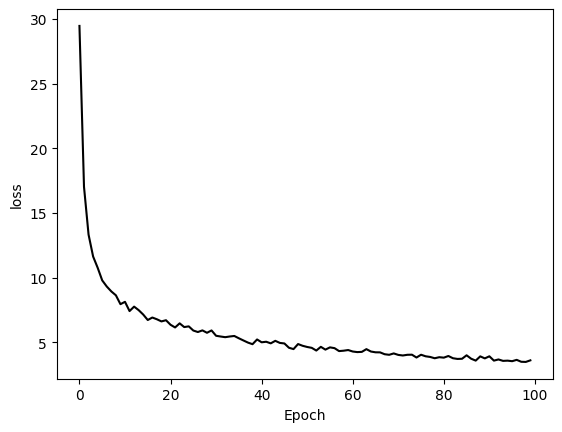

In [7]:
# Make a dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, size):
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        x = torch.tensor(X[index]).float().to(DEVICE)
        return x.view(1, -1) # add the channel

dataset = Dataset(len(X))
checkpoints_directory = "score_xray_clusters_20230731_2"
model = NCSNpp(channels=1, dimensions=1, nf=64, ch_mult=(2, 2)).to(DEVICE)
score_model = ScoreModel(model, sigma_min=1e-3, sigma_max=200)

losses = score_model.fit(
    dataset, 
    checkpoints_directory=checkpoints_directory, 
    epochs=100,
    batch_size=32, 
    learning_rate=1e-3,
    checkpoints=3,
    models_to_keep=3,
    ema_decay=0.99,
    max_time=1
)

plt.plot(losses, "-k")
plt.ylabel("Loss")
plt.xlabel("Epoch")

# Sampling from the prior

In [413]:
# # Load the score model if checkpointing to avoid having to run the cell above the model
checkpoints_directory = "../models/score_xray_clusters_20230731_2"
score_model = ScoreModel(checkpoints_directory=checkpoints_directory, dimensions=1)

In [414]:
n = 100
em_steps = 200
samples = score_model.sample(n=100, shape=[1, 140], steps=em_steps) # around 1 min on PC

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:58<00:00,  3.43it/s]


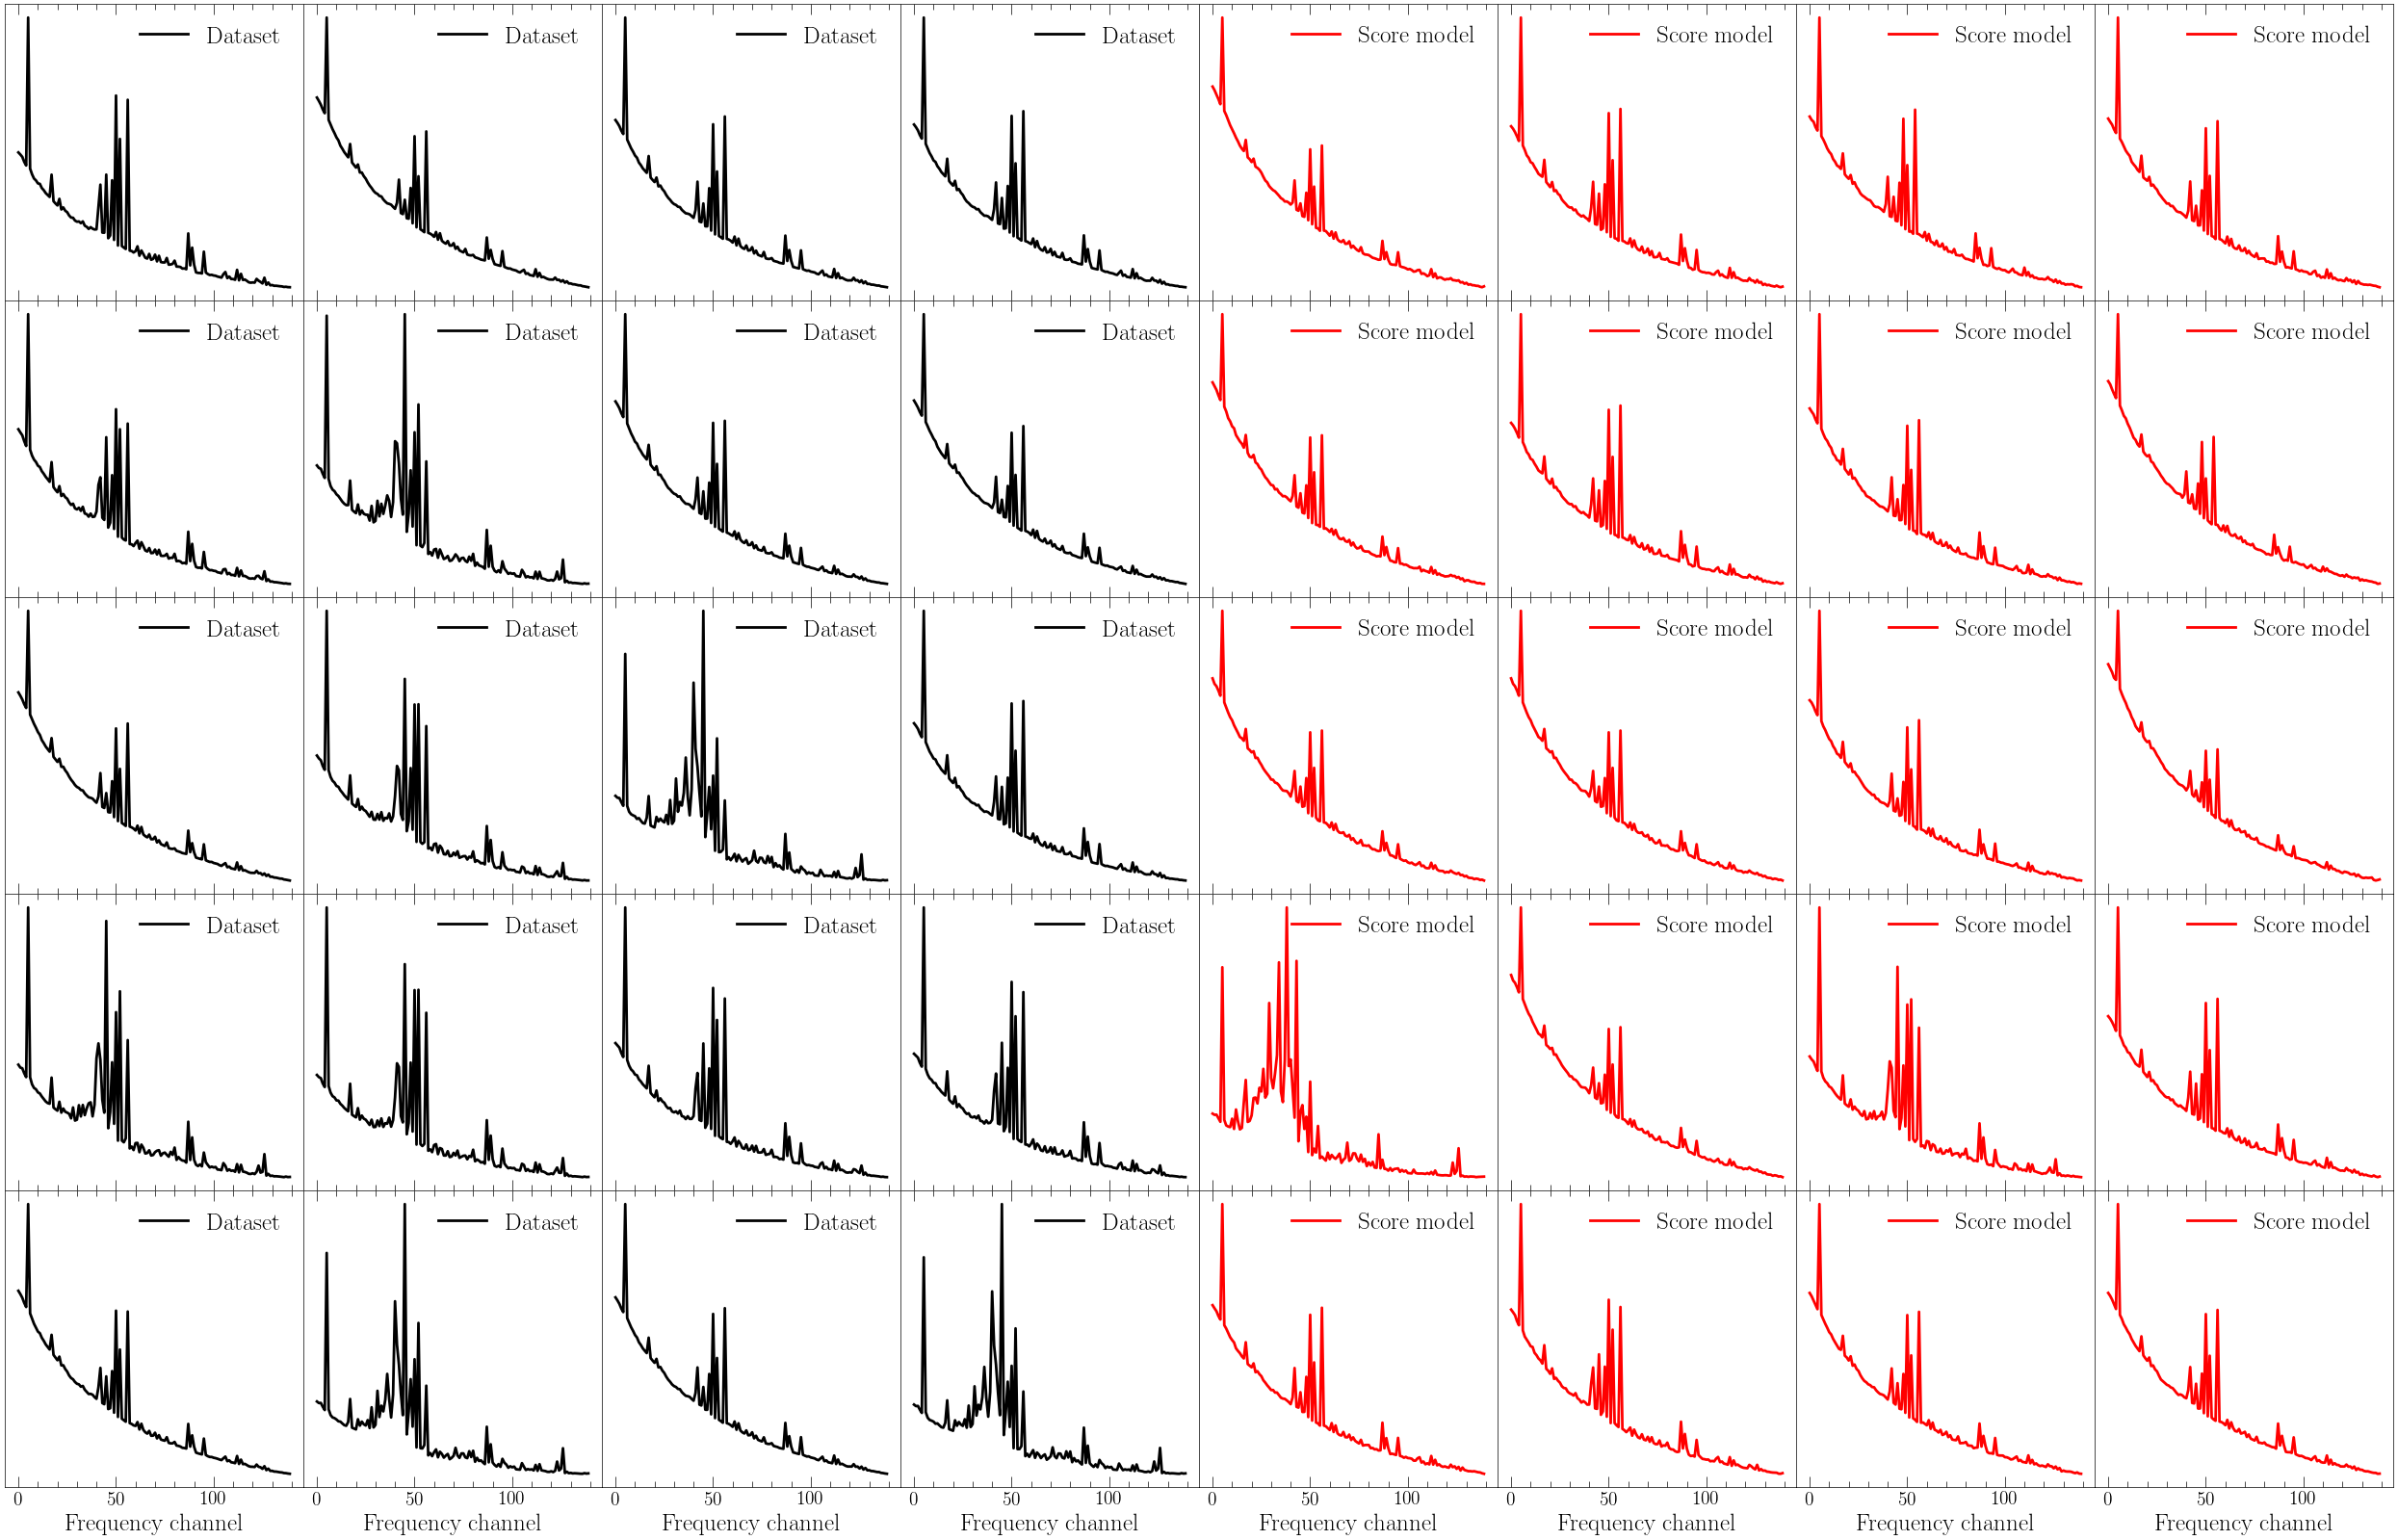

In [291]:
fig, axs = plt.subplots(5, 8, figsize=(32, 20), sharex=True)

for i in range(5):
    for j in range(4):
        k = np.random.randint(len(X))
        x = X[k]
        axs[i, j].plot(x, "-k", lw=2, label="Dataset")
        axs[i, j].legend(fontsize=18)
        axs[i, j].set_xlabel("Frequency channel")
        axs[i, j].get_yaxis().set_visible(False)

        k = np.random.randint(n)
        x = samples[k].cpu().squeeze()
        axs[i, 4+j].plot(x, "-r", lw=2,  label="Score model")
        axs[i, 4+j].legend(fontsize=18)
        axs[i, 4+j].set_xlabel("Frequency channel")
        axs[i, 4+j].get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig("../results/prior_samples.png")

# Sampling from the posterior

In [ ]:
# # Load the score model if checkpointing to avoid having to retrain the model
# checkpoints_directory = "score_xray_clusters_20230731_2"
# score_model = ScoreModel(checkpoints_directory=checkpoints_directory, dimensions=1)

In [334]:
responses_data = pickle.load(open('../data/RIM_clusters/rmfs_original.pkl', 'rb'))
A_dataset = np.stack([responses_data[val][min_:max_,min_:max_].T for val in responses_data]) # Need to use the tranpose of the dataset, saved in wrong order

In [335]:
def likelihood_score_fn(t, x, y, A, sigma_n, ridge=1e-1): # make sure to respect this signature (x, y, *args)
    """
    Annealed likelihood with the SDE of the diffusion model. 
    
    Naturally, this function has dimensions problems and will need to be vmapped over in the appropriate 
    way later. Notice the covariance which includes the for A @ A.T * sigma(t) factor. This factors 
    accounts for that noise that is introduced during the diffusion in the model space.
    
    Derivation of this term e.g. in Adam et al. (2022) https://arxiv.org/abs/2211.03812 Appendix A
    
    We also add a ridge regularisation to remove high frequency noise from the A @ A.T operator. This 
    is quite crucial since the operator A is a rather singular and badly behaved operator and will 
    have bad effects on the diffusion. This statement can be made more concrete by measuring the 
    Lipshitz constant of the likelihood score, which should not exceed 1 (to be done)
    """
    n = y.shape[0]
    Sigma_y = torch.eye(n) * sigma_n**2
    Sigma_t = (A @ A.T + ridge * torch.eye(n)) * score_model.sde.sigma(t)**2
    precision = (Sigma_y + Sigma_t).inverse()
    y_pred = A @ x.squeeze() # remove channel dimension of x.
    score = (y - y_pred).T @ precision @ A
    return score.unsqueeze(0) # give score back its channel dimensions

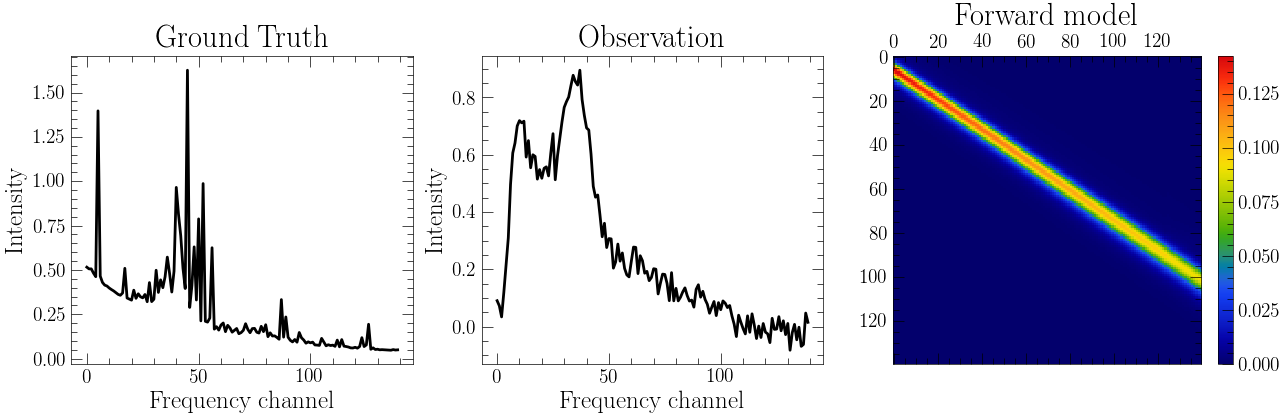

In [426]:
# sample a response matrix
k = np.random.randint(len(A_dataset))
A = A_dataset[k]

# Pick a ground truth
k = np.random.randint(len(X))
x_true = X[k]

# Pick an SNR
snr = 50
sigma_n = x_true.max() / snr

# Make the observation
y = A @ x_true
y += np.random.randn(*y.shape) * sigma_n

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Ground Truth")
ax1.plot(x_true, "-k", lw=2)
ax1.set_xlabel("Frequency channel")
ax1.set_ylabel("Intensity")

ax2.set_title("Observation")
ax2.plot(y, "-k", lw=2)
ax2.set_xlabel("Frequency channel")
ax2.set_ylabel("Intensity")

ax3.set_title("Forward model")
# cmap = cc.cm["CET_CBTL2"]
cmap = cc.cm["rainbow4"]
im = ax3.matshow(A, cmap=cmap)
plt.colorbar(im, ax=ax3, fraction=0.046)

In [427]:
# Send A and observation to tensor
A_tensor = torch.tensor(A).float().to(DEVICE)
y_tensor = torch.tensor(y).float().to(DEVICE)
# Wrap our likelihood score function to have correct signature for diffusion. Use vmap to deal with batch size
score_fn = vmap(lambda t, x: likelihood_score_fn(t, x, y_tensor, A_tensor, sigma_n))

# Quick test that our setup indeed works
t = torch.rand([10]).to(DEVICE)
x = torch.randn([10, 1, 140]).to(DEVICE)
score_fn(t, x).shape

torch.Size([10, 1, 140])

In [428]:
# Now use score_fn with score_models sampling function introduced in version 0.4.7
n = 50 # number of posterior samples to draw
shape = [1, 140]
em_steps = 300 # use more steps for posterior sampling
guidance_factor = 1 # multiplicative factor for the likelihood. Use 1 for posterior sampling. 
posterior_samples = score_model.sample(n, shape, em_steps, score_fn, guidance_factor)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:37<00:00,  7.99it/s]


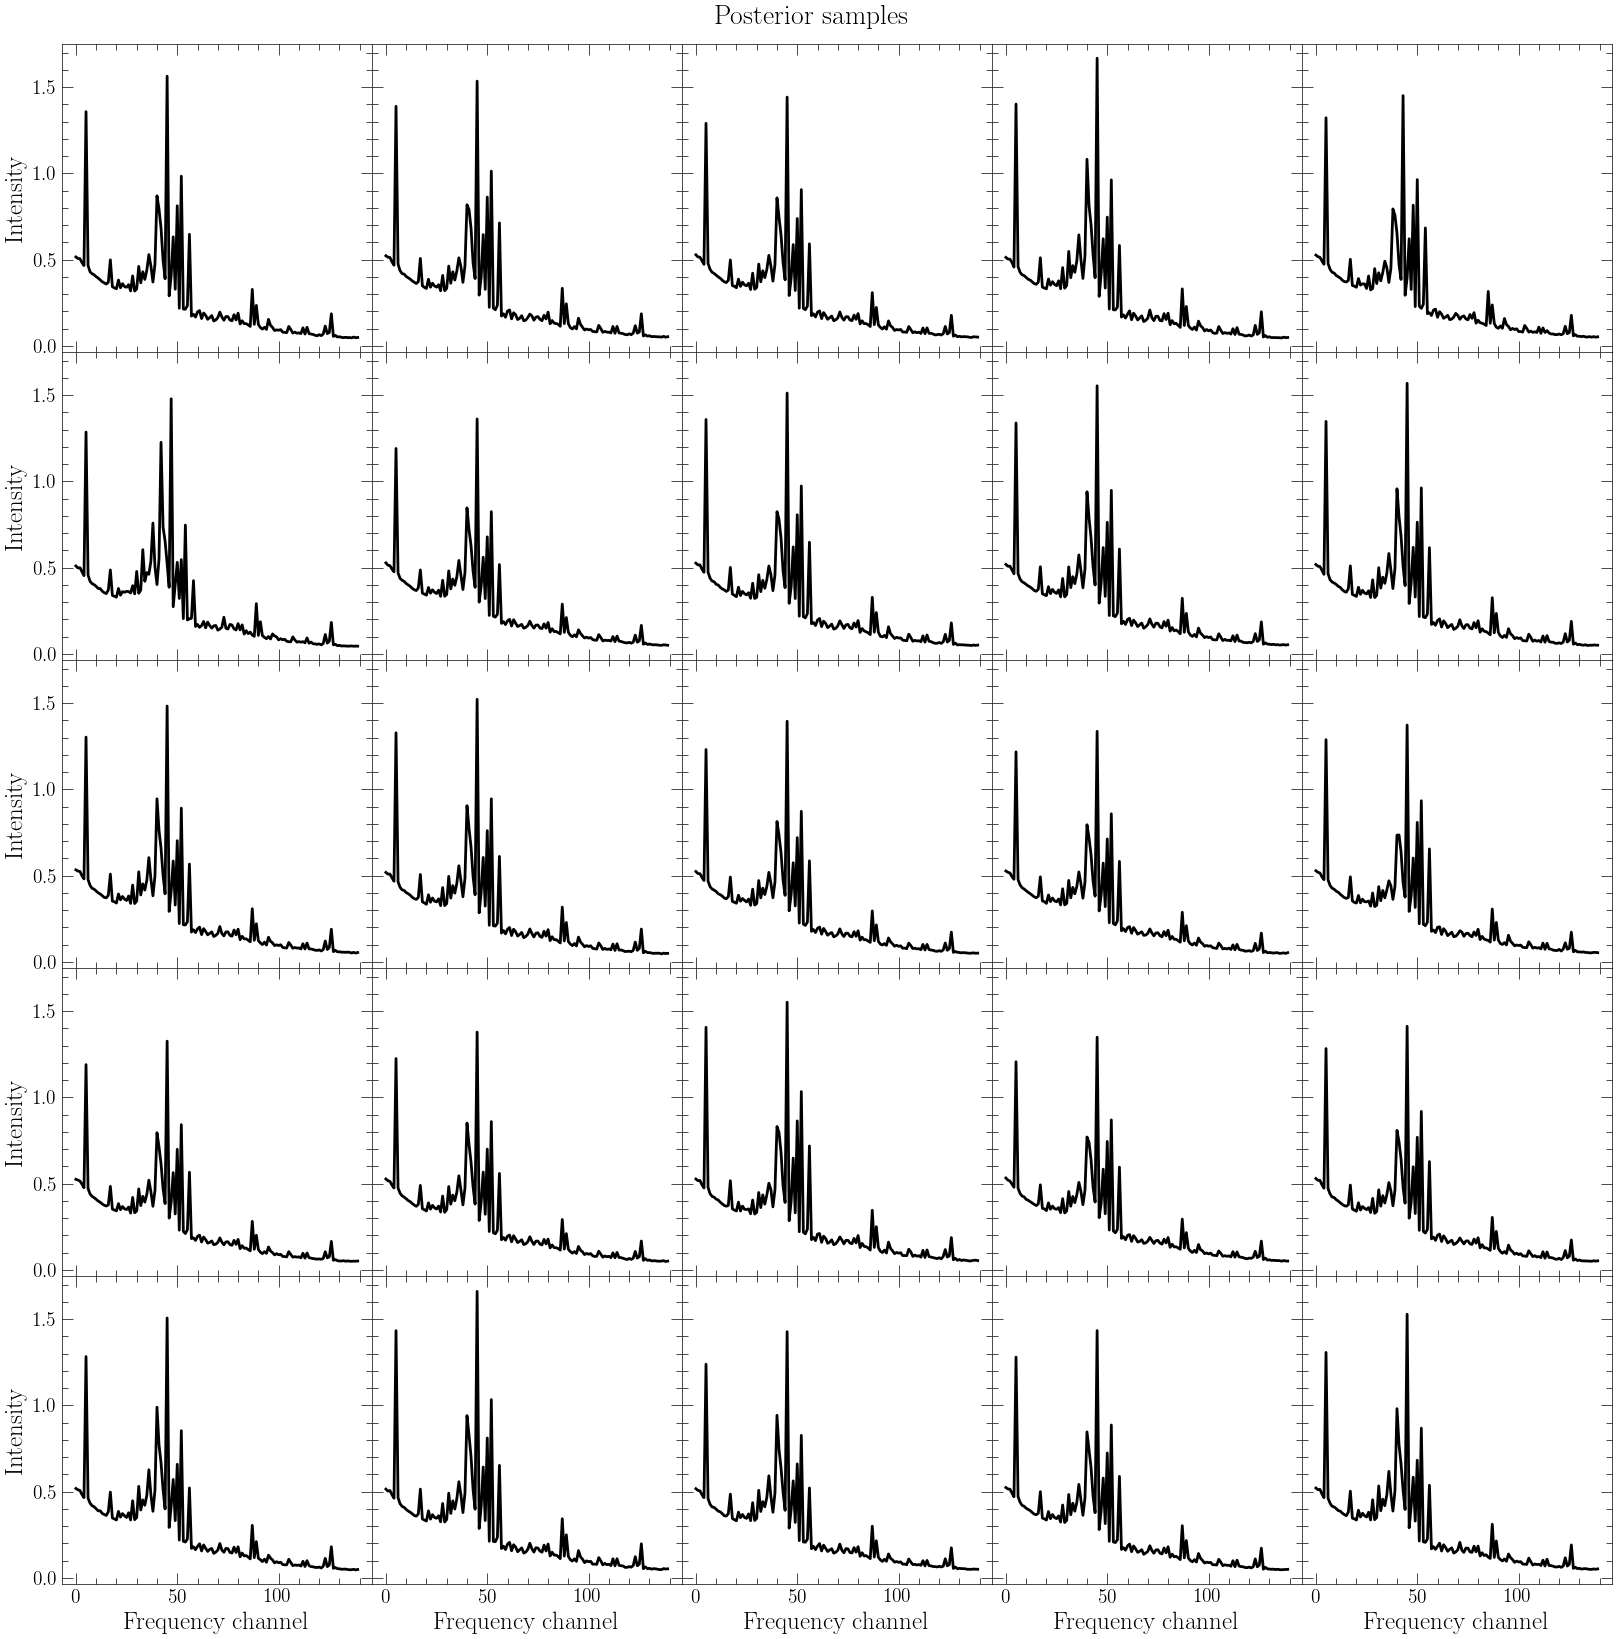

In [429]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20), sharex=True, sharey=True)

for i in range(5):
    for j in range(5):
        k = i * 5 + j
        axs[i, j].plot(posterior_samples[k].cpu().squeeze(), "-k", lw=2)
        if i == 4:
            axs[i, j].set_xlabel("Frequency channel")
        if j == 0:
            axs[i, j].set_ylabel("Intensity")
fig.suptitle("Posterior samples", y=0.90, fontsize=20)
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig("../results/simulation_posterior_samples_20230731.png")

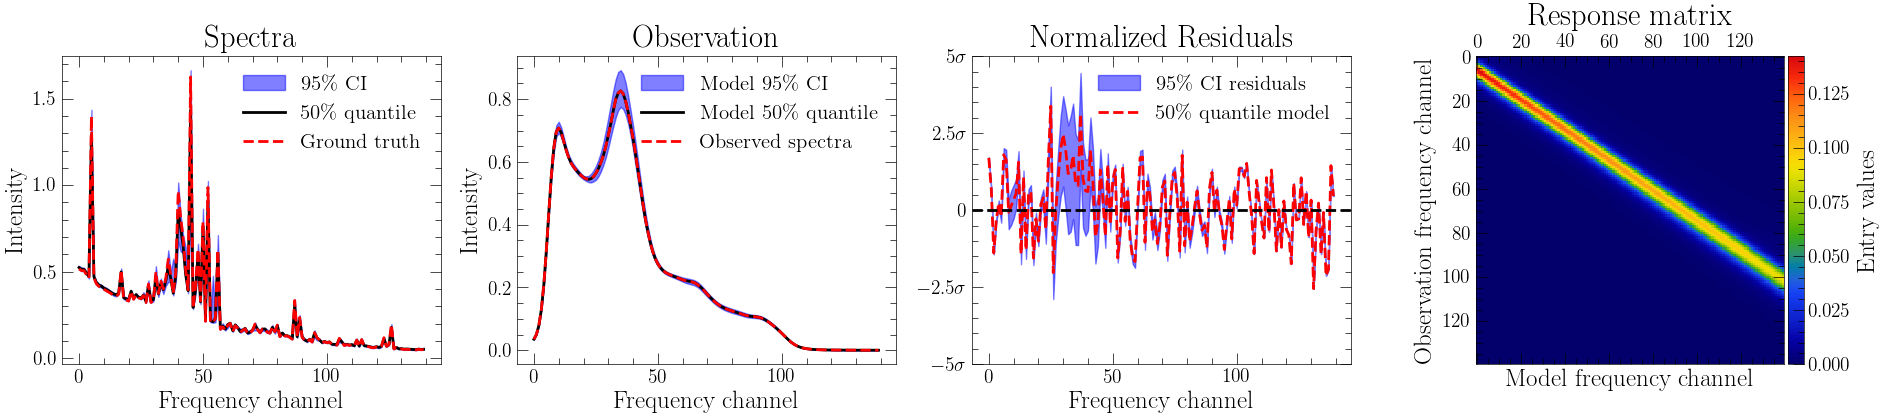

In [430]:
cfig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(4.5*5, 4))
post_samples = posterior_samples.numpy().squeeze()

q95 = np.quantile(post_samples, axis=0, q=0.95)
q50 = np.quantile(post_samples, axis=0, q=0.5)
q05 = np.quantile(post_samples, axis=0, q=0.05)


ax1.fill_between(range(len(q95)), q05, q95, color="blue", alpha=0.5, label=r"$95\%$ CI")
ax1.plot(q50, "-k", lw=2, label=r"$50\%$  quantile")
ax1.plot(x_true, "--r", lw=2, label="Ground truth")
ax1.set_title(r"Spectra")
ax1.set_xlabel("Frequency channel")
ax1.set_ylabel("Intensity")
ax1.legend(fontsize=15)

y_pred = vmap(torch.matmul, in_dims=(None, 0))(A_tensor, posterior_samples.squeeze())
yq95 = np.quantile(y_pred, axis=0, q=0.95)
yq50 = np.quantile(y_pred, axis=0, q=0.5)
yq05 = np.quantile(y_pred, axis=0, q=0.05)

ax2.fill_between(range(len(yq95)), yq05, yq95, color="blue", alpha=0.5, label=r"Model $95\%$ CI")
ax2.plot(yq50, "-k", lw=2, label=r"Model $50\%$  quantile")
ax2.plot(yq50, "--r", lw=2, label=r"Observed spectra")
ax2.set_title(r"Observation")
ax2.set_xlabel("Frequency channel")
ax2.set_ylabel("Intensity")
ax2.legend(fontsize=15)

residuals = (y_tensor.view(1, -1) - y_pred).numpy() / sigma_n
rq95 = np.quantile(residuals, axis=0, q=0.95)
rq50 = (y_tensor - yq50).numpy() / sigma_n
rq05 = np.quantile(residuals, axis=0, q=0.05)

ax3.fill_between(range(len(rq95)), rq05, rq95, color="blue", alpha=0.5, label=r"$95\%$ CI residuals")
ax3.plot(rq50, "--r", lw=2, label=r"$50\%$  quantile model")
ax3.axhline(0, color="k", lw=2, ls="--") 
ax3.set_title(r"Normalized Residuals")
ax3.set_xlabel("Frequency channel")
ax3.set_yticks([-5, -2.5, 0, 2.5, 5], labels=[r"$-5\sigma$", r"$-2.5\sigma$", r"$0$", r"$2.5\sigma$", r"$5\sigma$"])
ax3.legend(fontsize=15)

cmap = cc.cm["rainbow4"]
im = ax4.matshow(A, cmap=cmap)
cbar = plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.01)
ax4.set_ylabel("Observation frequency channel")
ax4.set_xlabel("Model frequency channel")
ax4.set_title("Response matrix")
cbar.set_label("Entry values")

plt.savefig("../results/simulation_posterior_summary_20230731.png")

# Inference on real data

In [415]:
from astropy.io import fits
spectrum_name = '../data/25678.pi'
spectrum_response = '../data/25678_rmf.img'

spectrum = fits.open(spectrum_name)
spectrum = spectrum[1].data
spectrum_axis = [s1[0] for s1 in spectrum[35:175]]
spectrum_counts = [np.array([s1[3] for s1 in spectrum[35:175]])]


# Need to ask Carter about units. For now use ducktape and some intuition
spectrum_counts = spectrum_counts[0] * 10 # * 10 is some ducktape

# Load combined response matrix
response = fits.open(spectrum_response)
response = response[0].data
response = response[35:175, 35:175]
# ducktape the forward model
response = response.T / response.sum(axis=1).max() # ducktape + need the transpose response!

In [416]:
# Get a rough estimate of the noise level
sigma_n = spectrum_counts.std() / 5 # ducktape so that noise in our fake obs match what is observed roughly
sigma_n

0.016728029994535258

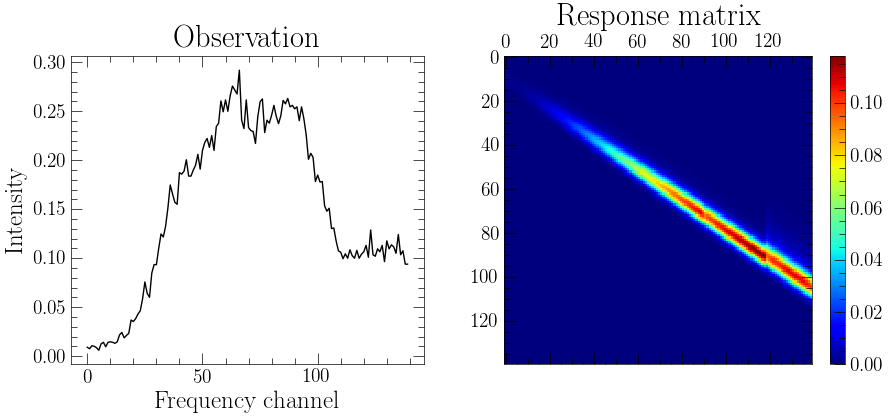

In [417]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(10, 4))

ax2.set_title("Observation")
ax2.plot(spectrum_counts, "-k")
ax2.set_xlabel("Frequency channel")
ax2.set_ylabel("Intensity")

ax3.set_title("Response matrix")
im = ax3.matshow(response, cmap="jet")
plt.colorbar(im, ax=ax3, fraction=0.046)

In [418]:
# # Check that the forward model make sense, pick some ground truth from the dataset and plot it's observation
# # Pick the data forward model
# A = response

# # Pick a ground truth
# k = np.random.randint(len(X))
# x_true = X[k]

# # Make a fake observation
# y = A @ x_true
# y += np.random.randn(*y.shape) * sigma_n

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# ax1.set_title("Ground Truth")
# ax1.plot(x_true, "-k")
# ax1.set_xlabel("Frequency channel")
# ax1.set_ylabel("Intensity")

# ax2.set_title("Observation")
# ax2.plot(y, "-k")
# ax2.set_xlabel("Frequency channel")
# ax2.set_ylabel("Intensity")

# ax3.set_title("Forward model")
# im = ax3.matshow(A, cmap="jet")
# plt.colorbar(im, ax=ax3, fraction=0.046)


# After ducktaping our forward model, we now proceed to do inference

In [419]:
y_tensor = torch.tensor(spectrum_counts).float().to(DEVICE)
A_tensor = torch.tensor(response).float().to(DEVICE)
# Wrap our likelihood score function to have correct signature for diffusion. Use vmap to deal with batch size
score_fn = vmap(lambda t, x: likelihood_score_fn(t, x, y_tensor, A_tensor, sigma_n))


In [420]:
# Now use score_fn with score_models sampling function introduced in version 0.4.7
n = 50 # number of posterior samples to draw
shape = [1, 140]
em_steps = 500 # use more steps for posterior sampling
guidance_factor = 1 # multiplicative factor for the likelihood. Use 1 for posterior sampling. 
posterior_samples = score_model.sample(n, shape, em_steps, score_fn, guidance_factor)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.57it/s]


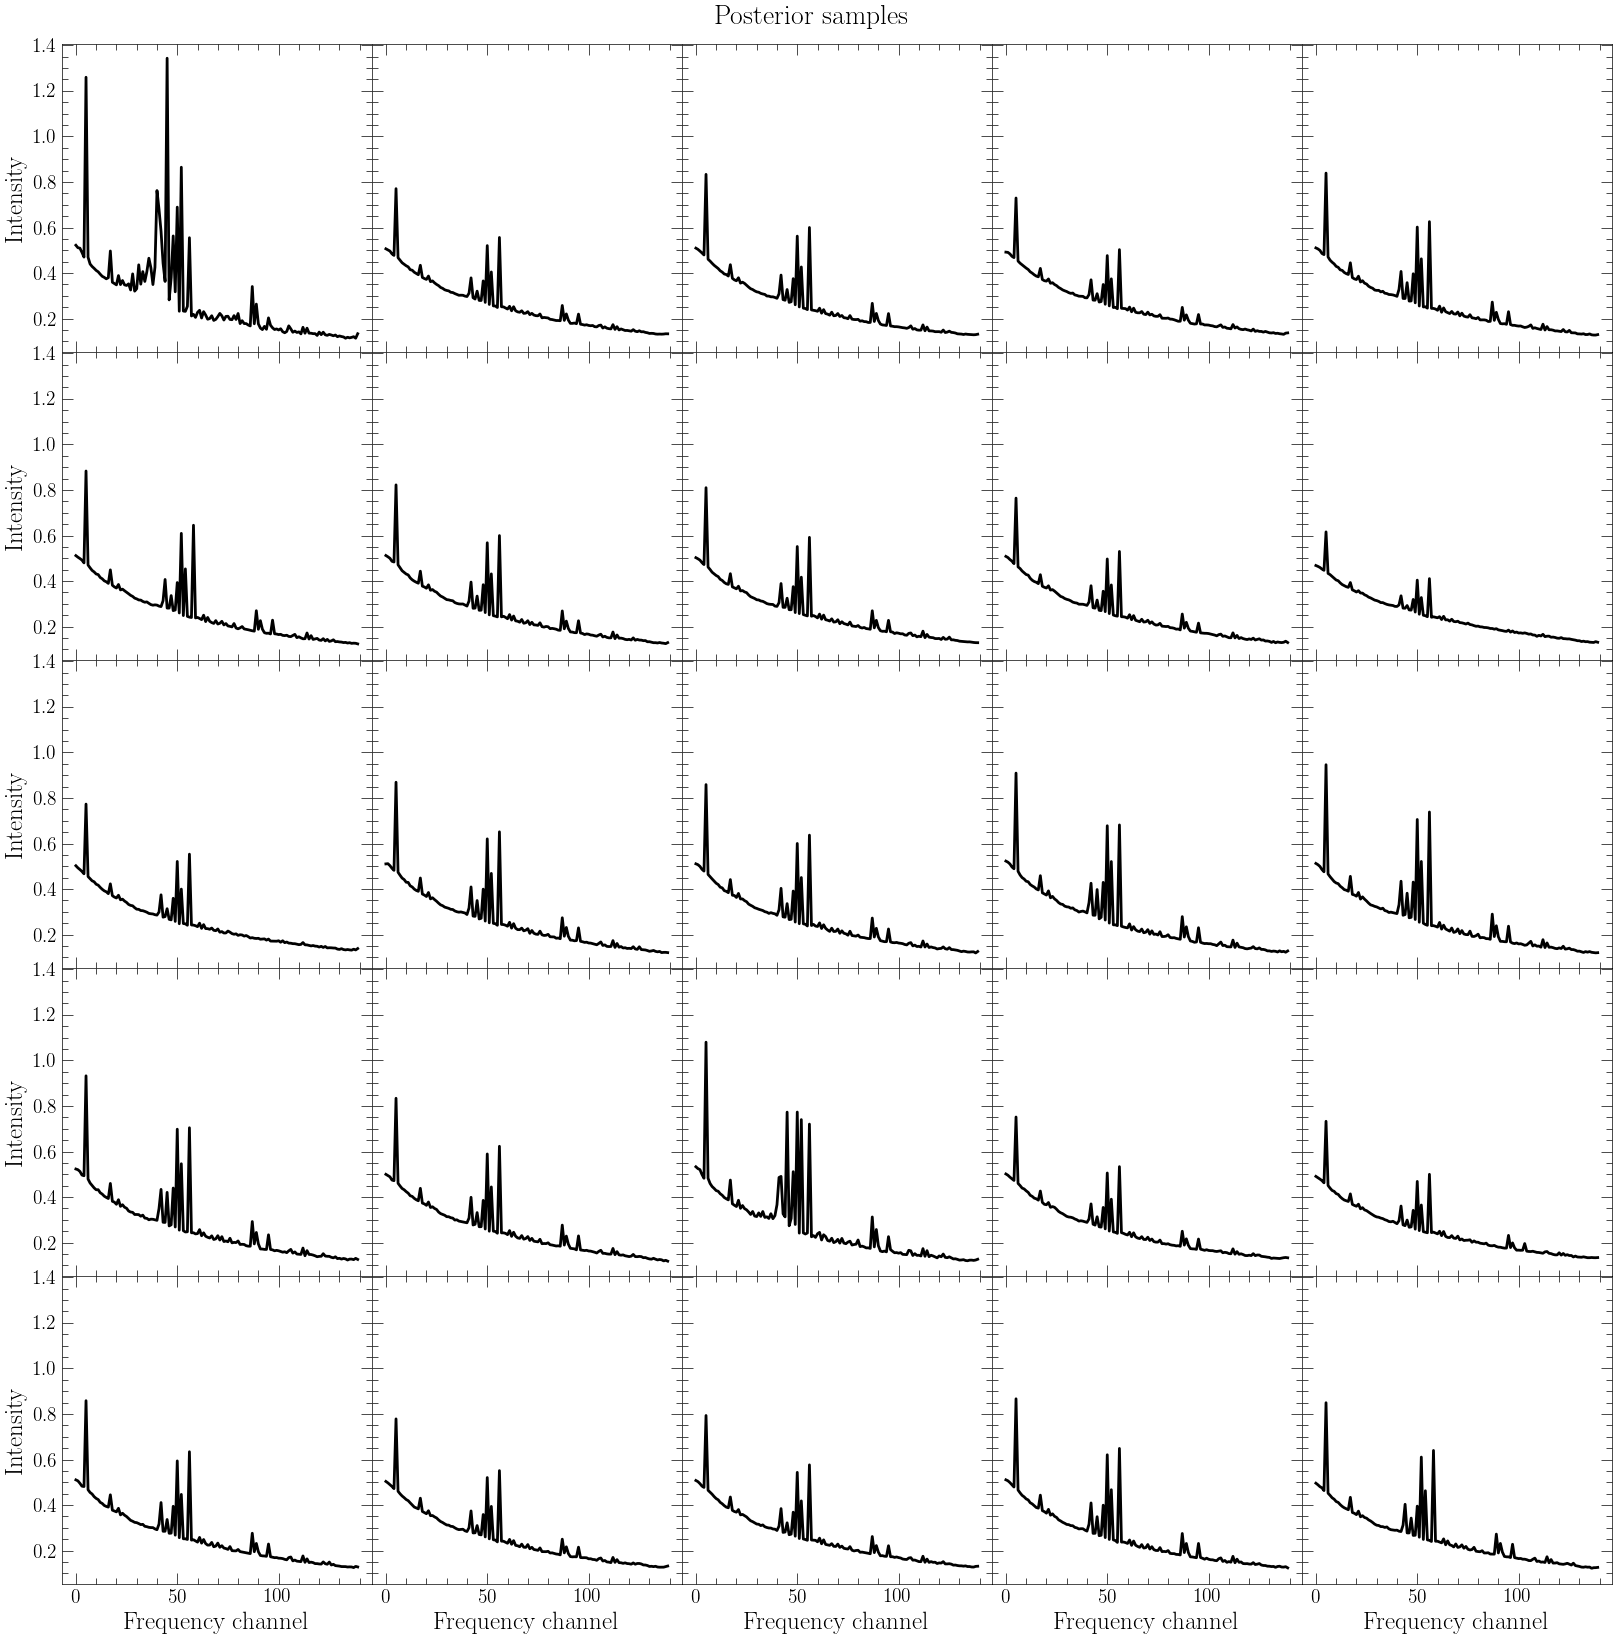

In [421]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20), sharex=True, sharey=True)

for i in range(5):
    for j in range(5):
        k = i * 5 + j
        axs[i, j].plot(posterior_samples[k].cpu().squeeze(), "-k", lw=2)
        if i == 4:
            axs[i, j].set_xlabel("Frequency channel")
        if j == 0:
            axs[i, j].set_ylabel("Intensity")
fig.suptitle("Posterior samples", y=0.90, fontsize=20)
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig("../results/real_data_posterior_samples_20230731.png")

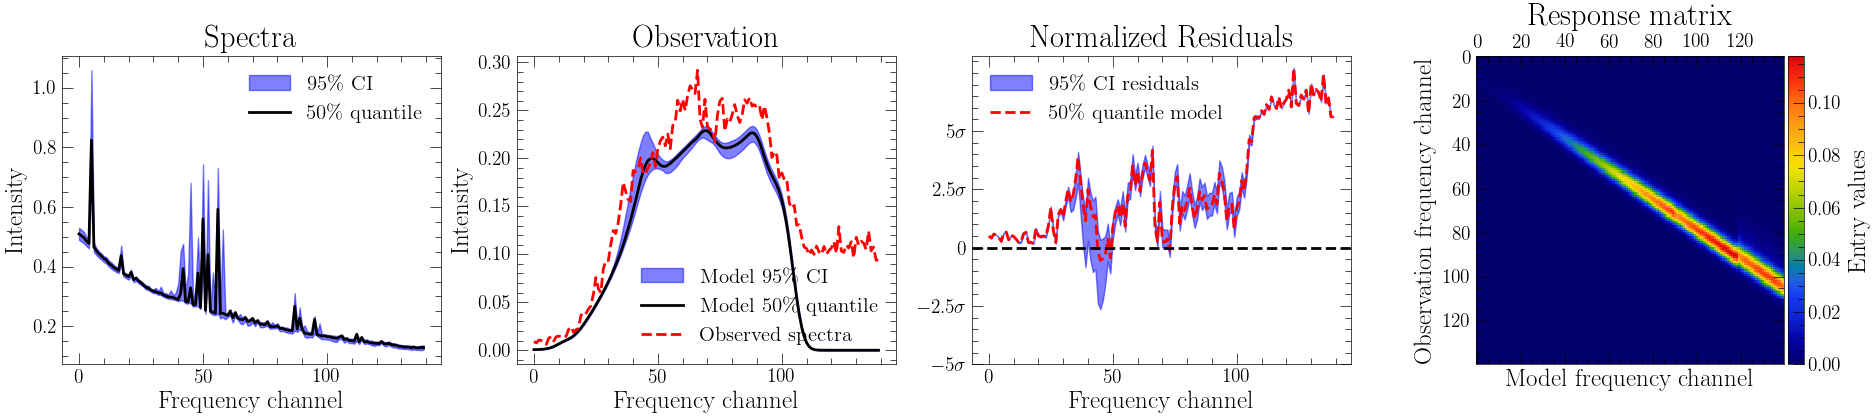

In [422]:
cfig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(4.5*5, 4))
post_samples = posterior_samples.numpy().squeeze()

q95 = np.quantile(post_samples, axis=0, q=0.95)
q50 = np.quantile(post_samples, axis=0, q=0.5)
q05 = np.quantile(post_samples, axis=0, q=0.05)

ax1.fill_between(range(len(q95)), q05, q95, color="blue", alpha=0.5, label=r"$95\%$ CI")
ax1.plot(q50, "-k", lw=2, label=r"$50\%$  quantile")
ax1.set_title(r"Spectra")
ax1.set_xlabel("Frequency channel")
ax1.set_ylabel("Intensity")
ax1.legend(fontsize=15)

y_pred = vmap(torch.matmul, in_dims=(None, 0))(A_tensor, posterior_samples.squeeze())
yq95 = np.quantile(y_pred, axis=0, q=0.95)
yq50 = np.quantile(y_pred, axis=0, q=0.5)
yq05 = np.quantile(y_pred, axis=0, q=0.05)

ax2.fill_between(range(len(yq95)), yq05, yq95, color="blue", alpha=0.5, label=r"Model $95\%$ CI")
ax2.plot(yq50, "-k", lw=2, label=r"Model $50\%$  quantile")
ax2.plot(spectrum_counts, "--r", lw=2, label=r"Observed spectra")
ax2.set_title(r"Observation")
ax2.set_xlabel("Frequency channel")
ax2.set_ylabel("Intensity")
ax2.legend(fontsize=15)

residuals = (y_tensor.view(1, -1) - y_pred).numpy() / sigma_n
rq95 = np.quantile(residuals, axis=0, q=0.95)
rq50 = (y_tensor - yq50).numpy() / sigma_n
rq05 = np.quantile(residuals, axis=0, q=0.05)

ax3.fill_between(range(len(rq95)), rq05, rq95, color="blue", alpha=0.5, label=r"$95\%$ CI residuals")
ax3.plot(rq50, "--r", lw=2, label=r"$50\%$  quantile model")
ax3.axhline(0, color="k", lw=2, ls="--") 
ax3.set_title(r"Normalized Residuals")
ax3.set_xlabel("Frequency channel")
ax3.set_yticks([-5, -2.5, 0, 2.5, 5], labels=[r"$-5\sigma$", r"$-2.5\sigma$", r"$0$", r"$2.5\sigma$", r"$5\sigma$"])
ax3.legend(fontsize=15)

cmap = cc.cm["rainbow4"]
im = ax4.matshow(response, cmap=cmap)
cbar = plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.01)
ax4.set_ylabel("Observation frequency channel")
ax4.set_xlabel("Model frequency channel")
ax4.set_title("Response matrix")
cbar.set_label("Entry values")

plt.savefig("../results/real_data_posterior_summary_20230731.png")